# Import packages
Note: This notebook can take a while (~5 min) for the first time due to compilation

In [1]:
from pyrms import rms
from diffeqpy import de
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Change simulation inputs here
`mechanism_path`: path to the generated rms input file

`initial_conds`: a dictionary containing the initial conditions, where
- `T`: temperature (K)
- `P`: pressure (Pa)
- `H2`: number of moles of H2
- `O2`: number of moles of O2

`tspan`: the simulation time span ($t_0$, $t_f$) in second

In [2]:
mechanism_path = "rms/chem13.rms"
initial_conds = {"T": 1000.0, "P": 10.0e5, "H2": 0.67, "O2": 0.33}
tspan = (0.0, 0.02)

### Load the mechanism

In [3]:
phase_dict = rms.readinput(mechanism_path)
spcs = phase_dict["phase"]["Species"]
rxns = phase_dict["phase"]["Reactions"]

RDKit WARNING: [00:02:46] WARNING: not removing hydrogen atom without neighbors
[00:02:46] WARNING: not removing hydrogen atom without neighbors


### Make the ideal gas phase
Phase controls how the thermochemical and kinetic properties are calculated

In [4]:
ig = rms.IdealGas(spcs, rxns, name="gas")

### Set up the domain
Domain controls the assumptions made in the simulation

`ConstantVDomain`: assuming constant V

In [5]:
domain, y0, p = rms.ConstantVDomain(phase=ig, initialconds=initial_conds)

### Set up the reactor

In [6]:
react = rms.Reactor(domain, y0, tspan, p=p)

### Solve the ODEs

In [19]:
%%time
sol = de.solve(react.ode, de.CVODE_BDF(), abstol=1e-16, reltol=1e-8)

CPU times: user 6.72 ms, sys: 0 ns, total: 6.72 ms
Wall time: 6.64 ms


### Set up simulation object
for easy plotting and analysis

In [8]:
sim = rms.Simulation(sol, domain)

# Various types of sensitivity analyses

## Transitory sensitivities

### Plot reaction transitory sensitivities

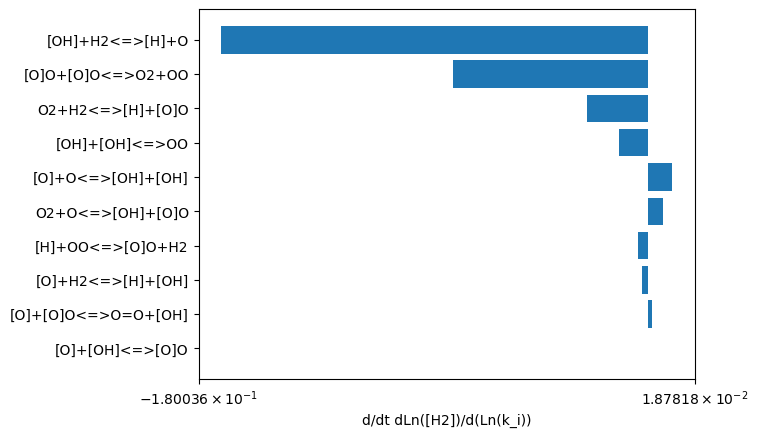

In [9]:
t = 0.02
rms.plotrxntransitorysensitivities(sim, "H2", t, N=10)

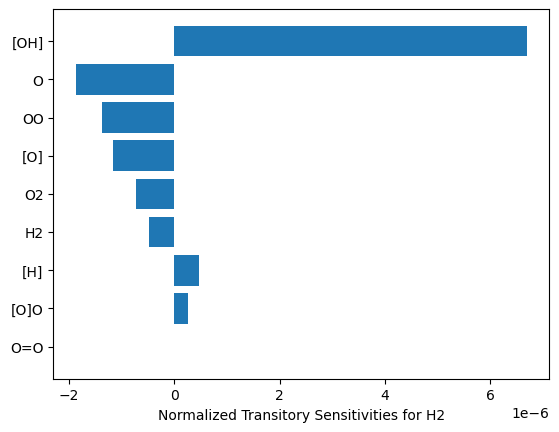

In [10]:
rms.plotthermotransitorysensitivities(sim, "H2", t, N=10)

# Adjoint sensitivity
Solve adjoint sensitivities for specified species

In [20]:
%%time
dps = rms.getadjointsensitivities(sim, "H2", de.CVODE_BDF())

CPU times: user 706 ms, sys: 93.3 ms, total: 799 ms
Wall time: 780 ms


## Plot adjoint sensitivities of reaction rates
The sensitivity is shown as $\frac{\mathrm{dln}N_{H_2}}{\mathrm{dln}k_f}$, where $\mathrm{ln}$ refers to the natural log, $N_{H_2}$ refers to the moles of $H_2$, and $k_f$ refers to the forward rate of each reactions.

- `dps`: the adjoint sensitivity results
- `N`: number of reactions to show

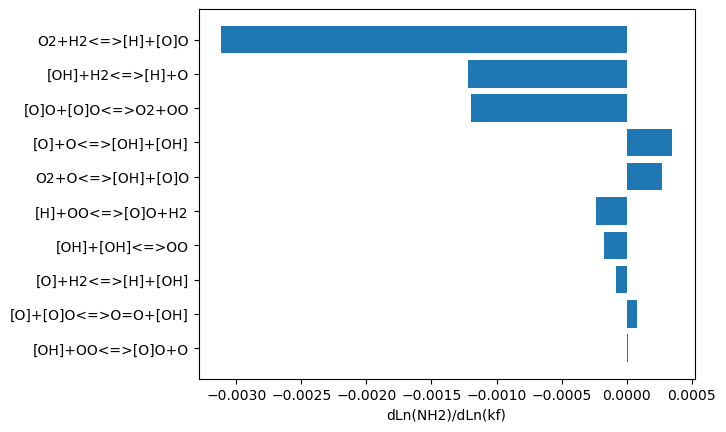

In [12]:
rms.plotrateadjointsensitivities(sim, "H2", dps, N=10)

## Plot adjoint sensitivities of thermochemistry
The sensitivity is shown as $\frac{\mathrm{dln}N_{H_2}}{\mathrm{d}G}$, where $G$ refers to the Gibbs free energy of formation of each species
- `dps`: the adjoint sensitivity results
- `N`: number of reactions to show

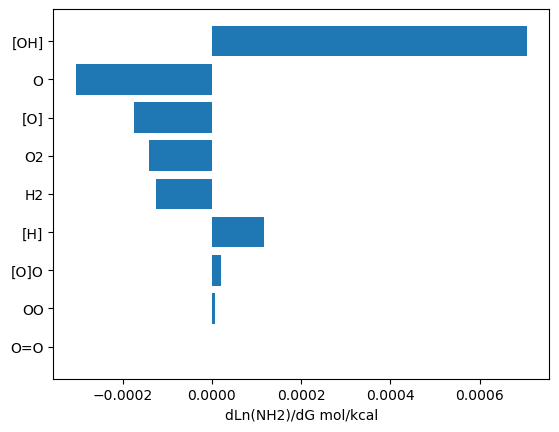

In [13]:
rms.plotthermoadjointsensitivities(sim, "H2", dps, N=10)

# Forward sensitivities
Solve for the forward sensitivity equations

In [14]:
react_fs = rms.Reactor(domain, y0, tspan, p=p, forwardsensitivities=True)

In [21]:
%%time
sol_fs = de.solve(react_fs.ode, de.CVODE_BDF(), abstol=1e-16, reltol=1e-8)

CPU times: user 1.67 s, sys: 759 ms, total: 2.43 s
Wall time: 2.33 s


In [16]:
sim_fs = rms.Simulation(sol_fs, domain)

## Plot forward sensitivities of reaction rates
The sensitivity is shown as $\frac{\mathrm{dln}[H_2]}{\mathrm{dln}k_f}$, where $\mathrm{ln}$ refers to the natural log, $[H_2]$ refers to the concentration of $H_2$, and $k_f$ refers to the forward rate of each reactions.

- `N`: number of reactions to show

Text(0.5, 0, 'dLn([H2])/d(Ln(k_i))')

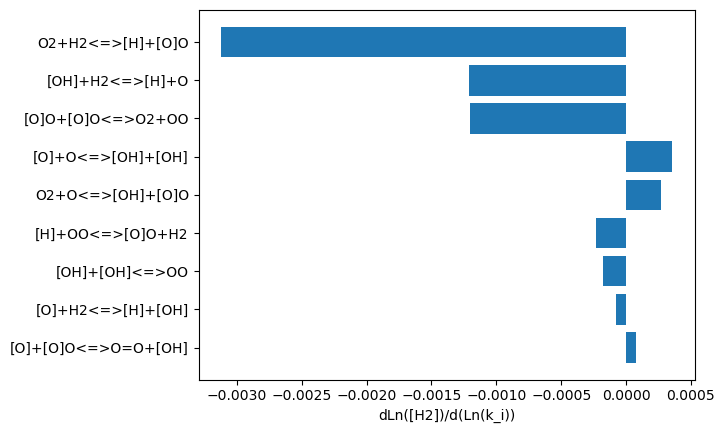

In [17]:
rms.plotmaxrateforwardsensitivity(sim_fs, "H2", N=10, tol=1e-5)

## Plot forward sensitivities of thermochemistry
The sensitivity is shown as $\frac{\mathrm{dln}[H_2]}{\mathrm{d}G}$, where $G$ refers to the Gibbs free energy of formation of each species
- `N`: number of reactions to show

Text(0.5, 0, 'dLn([H2])/d(G_i) mol/kcal')

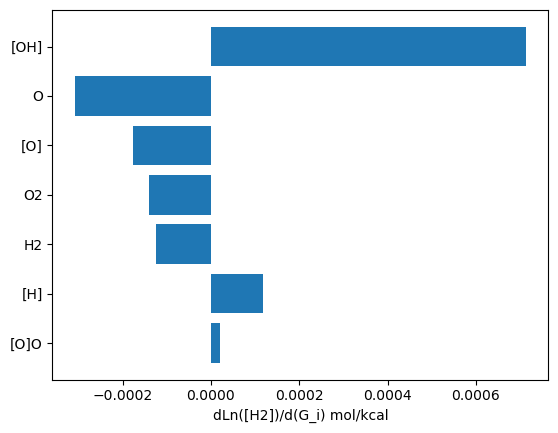

In [18]:
rms.plotmaxthermoforwardsensitivity(sim_fs, "H2", N=10, tol=1e-5)